In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from common_variables import *

2025-03-27 22:20:00.997875: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-03-27 22:20:00.997896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
pred_interval = 2
pred_size = 3 # Prediction length into the future
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(test_time_series_path, index_col=0)
df

,PC1,PC2,PC3,PC4,open,high,low,close,SMA_50,SMA_200,...,MACD,Signal_Line,Bollinger_Upper,Bollinger_Lower,ATR,K,D,J,MA,Returns
time,,,,,,,,,,,,,,,,,,,,,
2022-08-10 13:00:00+00:00,-3.223318,-2.024469,-0.201104,0.093205,1.03243,1.03686,1.03052,1.03249,1.021192,1.023668,...,0.002056,0.000831,1.029180,1.013205,0.003393,68.001209,62.260986,79.481656,1.022292,0.001006
2022-08-10 17:00:00+00:00,-3.215649,-1.685139,0.167869,0.088808,1.03249,1.03283,1.02944,1.02975,1.021433,1.023555,...,0.002336,0.001132,1.029713,1.013153,0.003425,64.441783,62.987918,67.349511,1.023176,0.000864
2022-08-10 21:00:00+00:00,-3.208122,-1.666443,0.389373,-0.049453,1.02978,1.03047,1.02935,1.02982,1.021636,1.023431,...,0.002533,0.001412,1.030231,1.013040,0.003284,62.208887,62.728241,61.170180,1.023838,0.000647
2022-08-11 01:00:00+00:00,-3.197969,-1.379125,0.671884,-0.088853,1.02980,1.02981,1.02813,1.02831,1.021749,1.023295,...,0.002539,0.001638,1.030546,1.012953,0.003261,57.699082,61.051855,50.993537,1.024512,0.000658
2022-08-11 05:00:00+00:00,-3.226325,-2.081553,0.396028,0.260262,1.02832,1.03414,1.02754,1.03411,1.021991,1.023188,...,0.002977,0.001905,1.031457,1.012525,0.003646,66.297187,62.800299,73.290964,1.025323,0.000791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21 01:00:00+00:00,-1.567879,2.126618,0.645338,-0.250608,1.08530,1.08556,1.08275,1.08304,1.089069,1.058738,...,-0.001182,-0.000155,1.095358,1.082780,0.002971,26.188433,29.709775,19.145748,1.088478,-0.000681
2025-03-21 05:00:00+00:00,-1.564157,2.197181,0.610772,-0.169752,1.08303,1.08457,1.08199,1.08361,1.089038,1.058997,...,-0.001358,-0.000396,1.095420,1.082657,0.003053,24.372295,27.930615,17.255655,1.087720,-0.000696
2025-03-21 09:00:00+00:00,-1.561171,2.373766,0.625991,-0.043816,1.08359,1.08612,1.08248,1.08322,1.088994,1.059260,...,-0.001512,-0.000619,1.095508,1.082480,0.003192,21.895714,25.918981,13.849178,1.087051,-0.000615


In [4]:

scalers = joblib.load(scaler_path)
X_scaler = scalers['X_scaler']
y_scaler = scalers['y_scaler']
model = load_model(model_path)


2025-03-27 22:20:01.560627: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-03-27 22:20:01.568349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-27 22:20:01.569570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.54GiB deviceMemoryBandwidth: 938.86GiB/s
2025-03-27 22:20:01.569606: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-03-27 22:20:01.569626: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic libr

In [6]:
ret_col_index = df.columns.get_loc('Returns')
scaled_X = X_scaler.transform(df.iloc[:, :4])  # Exclude last column for scaling
scaled_y = y_scaler.transform(df.iloc[:, ret_col_index].values.reshape(-1,1))

In [7]:
def calculate_dynamic_position_size(account_equity, atr, rsi, macd, risk_per_trade = 0.01, pip_value = 0.0001 ,stop_loss_pips = 20):
    
    # Risk management based on ATR (volatility)
    volatility_factor = 1 + (atr / 0.001)  # Adjusting for higher volatility
    
    # Adjusting for momentum (RSI and MACD)
    if rsi > 70:  # Overbought
        momentum_factor = 0.5  # Reduce position size in overbought market
    elif rsi < 30:  # Oversold
        momentum_factor = 1.5  # Increase position size in oversold market
    elif macd > 0:  # Bullish trend
        momentum_factor = 1.2  # Increase position size in bullish trend
    else:  # Bearish trend
        momentum_factor = 0.8  # Decrease position size in bearish trend
    
    # Calculate the base position size
    base_position_size = (account_equity * risk_per_trade) / (stop_loss_pips * pip_value)
    
    # Apply volatility and momentum adjustments
    adjusted_position_size = base_position_size * volatility_factor * momentum_factor
    
    return adjusted_position_size


In [8]:
hold = 0
max = 0
enter_equity = 10000
account_equity = enter_equity
abs_pips = 0.001
last_close_price = 0  # Track the exit price
asset = []
# Entry and Exit logic with dynamic position sizing
for i in range(window_size, df.shape[0] - pred_size, pred_interval):
    sma_50 = df.iloc[i-1, df.columns.get_loc('SMA_50')]
    sma_200 = df.iloc[i-1, df.columns.get_loc('SMA_200')]
    rsi = df.iloc[i-1, df.columns.get_loc('RSI')]
    macd = df.iloc[i-1, df.columns.get_loc('MACD')]
    signal_line = df.iloc[i-1, df.columns.get_loc('Signal_Line')]
    bollinger_upper = df.iloc[i-1, df.columns.get_loc('Bollinger_Upper')]
    bollinger_lower = df.iloc[i-1, df.columns.get_loc('Bollinger_Lower')]
    atr = df.iloc[i-1, df.columns.get_loc('ATR')]
    y_ma = df.iloc[i - 1, df.columns.get_loc('MA')]
    top_price = y_ma + abs_pips
    bottom_price = y_ma - abs_pips

    X = [scaled_X[i-window_size:i]]

    current_price = df.iloc[i-1, df.columns.get_loc('close')]
    asset.append(account_equity+hold*current_price)

    for _ in range(pred_size):
        X = np.asarray(X)
        X = np.reshape(X, (1, window_size, 4))
        y_pred_scaled = model.predict(X)
        y_return = y_scaler.inverse_transform(y_pred_scaled)
        y_ma = y_ma * np.exp(y_return) #predicate the average value

        # Add an ATR-based stop loss level
        stop_loss = current_price - (2 * atr)  # Example: 2 times ATR for stop loss

        #count = 0
        #count -= (y_ma <= bottom_price)+(rsi >= 30 and macd < 0)+current_price <= stop_loss

        if y_ma <= bottom_price or (rsi >= 30 and macd < 0) or current_price <= stop_loss:  # LSTM predicts a negative return (downward movement)
            # Calculate position size dynamically based on indicators
            num = calculate_dynamic_position_size(account_equity, atr, rsi, macd)
            if (hold == 0):
                break
            if (hold > num):
                account_equity += current_price * num
                hold -= num
            else:
                account_equity += current_price * hold
                hold = 0
            print("Exit (Sell) with price:", current_price)
            break

        # Entry and Exit conditions combining LSTM prediction and indicators
        elif y_ma >= top_price and (macd > 0 or rsi < 30):  # LSTM predicts a positive return (upward movement)
            num = calculate_dynamic_position_size(account_equity, atr, rsi, macd)
            if account_equity>current_price*num:
                account_equity -= current_price*num
            else:
                num = account_equity/current_price
                account_equity = 0
            hold += num
            print("Entry (Buy) with price:", current_price)
            break
                    
        

        

        # Prepare for next prediction
        X = np.delete(X, 0)
        X = np.append(X, y_pred_scaled)

    last_close_price = current_price  # Track the exit price

account_equity += last_close_price * hold
print("Total Profit: ", account_equity)
print("Profit rate:", (account_equity-enter_equity)/enter_equity)
print("Last price:", last_close_price)


Entry (Buy) with price: 0.9773
Exit (Sell) with price: 0.97245
Exit (Sell) with price: 0.97366
Entry (Buy) with price: 0.9844
Entry (Buy) with price: 0.98572
Entry (Buy) with price: 0.98601
Exit (Sell) with price: 0.97721
Exit (Sell) with price: 0.97783
Entry (Buy) with price: 0.98627
Entry (Buy) with price: 0.98478
Entry (Buy) with price: 0.98433
Entry (Buy) with price: 0.9873
Entry (Buy) with price: 0.98789
Entry (Buy) with price: 0.99677
Entry (Buy) with price: 0.99546
Entry (Buy) with price: 1.00045
Entry (Buy) with price: 1.00832
Entry (Buy) with price: 1.00704
Entry (Buy) with price: 1.00064
Exit (Sell) with price: 0.99849
Exit (Sell) with price: 0.99691
Exit (Sell) with price: 0.99654
Exit (Sell) with price: 0.99088
Exit (Sell) with price: 0.98824
Exit (Sell) with price: 0.99051
Exit (Sell) with price: 0.99408
Exit (Sell) with price: 0.98738
Exit (Sell) with price: 0.98841
Exit (Sell) with price: 0.9906
Exit (Sell) with price: 0.98143
Exit (Sell) with price: 0.98346
Exit (Sell) 

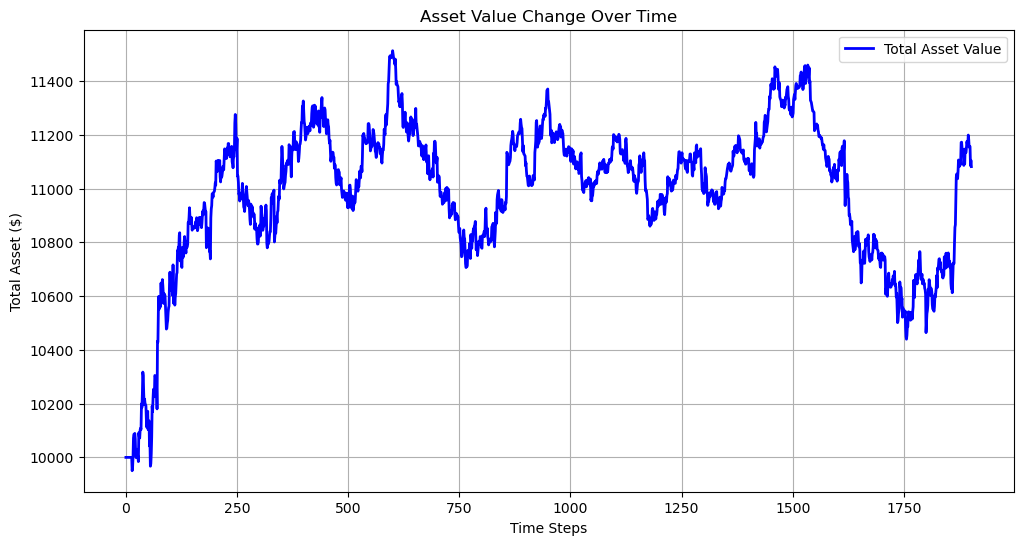

In [ ]:

# Plotting the asset value change over time
plt.figure(figsize=(12, 6))
plt.plot(asset, label="Total Asset Value", color="blue", linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Total Asset ($)")
plt.title("Asset Value Change Over Time")
plt.legend()
plt.grid(True)
plt.show()
